In [13]:
#Importing Libraries
from scipy import special
import numpy as np
import pandas as pd
import seaborn as sns
from math import comb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [14]:
#Aux Functions
def scurve(x):
    return 1/(1 + np.exp(-11 * (x - 0.5)))

In [15]:
DOMINANT = False                            #Switch between def allele being dominant or not

#Parameter values
P = {
    'pm' : 0.01,                            #Initial frequency of defender allele in males
    'pf' : 0.01,                            #Initial frequency of defender allele in females
    
    'C' : 20,                               #Number of eggs laid by non defender females
    'c' : 14,                               #Cost to females who defend (lower c = higher cost)
    'a' : 2,                                #Adv for non defender males in mating rate
    'u' : 0.1,                              #Probability female stays unmated
    'r' : 0.1,                              #Sex ration (Prob of male larvae in a mating)
}

def s(d, using = 's'):                      #Probability of the group surviving based on the proportion of defenders in the larvae

    if using == 'linear':
        return d * (0.99 - 0.01) + 0.01
    elif using == 'expinv':
        return ((np.exp(-d * 2.5) - np.exp(0))/(np.exp(-1 * 2.5) - np.exp(0))) * (0.99 - 0.01) + 0.01
    elif using == 'exp':
        return ((np.exp(2.5*d) - np.exp(0))/(np.exp(2.5*1) - np.exp(0))) * (0.99 - 0.01) + 0.01
    elif using == 's':
        return ((scurve(d) - scurve(0)) / (scurve(1) - scurve(0))) * (0.99 - 0.01) + 0.01

Text(0.5, 1.0, 'Shape of function s(d)')

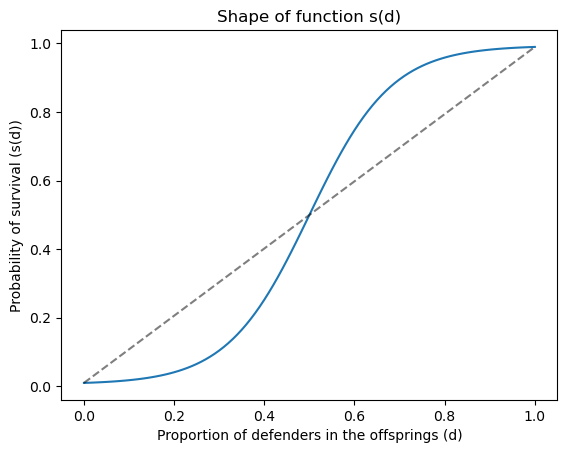

In [16]:
#The current shape of function s used for the simulations
d = np.linspace(0, 1, 101)
plt.plot(d, s(d))
plt.plot(d, np.linspace(0.01, 0.99, 101), 'k--', alpha = 0.5)
plt.xlabel('Proportion of defenders in the offsprings (d)')
plt.ylabel('Probability of survival (s(d))')
plt.title('Shape of function s(d)')

In [17]:
#Non matings
def f00(u, x00, C): #Results: M0 (1)
    if DOMINANT:
        return u * x00 * C * s(0)
    
    return u * x00 * C * s(0)

def f01(u, x01, C, c): #Results: M0 (0.5), M1 (0.5)
    S = 0
    if DOMINANT:
        k = np.arange(c+1.0)
        S = (special.comb(c, k) * (((0.5)**(k))*((0.5)**(c-k))) * s(k/c)).sum()
        #for k in range(c+1):
        #    S += comb(c, k) * (((0.5)**(k))*((0.5)**(c-k))) * s(k/c)

        return u * x01 * c * S
    
    k = np.arange(C+1.0)
    S = (special.comb(C, k) * (((0.5)**(k))*((0.5)**(C-k))) * s(k/C)).sum()
    #for k in range(C+1):
    #    S += comb(C, k) * (((0.5)**(k))*((0.5)**(C-k))) * s(k/C)

    return u * x01 * C * S

def f11(u, x11, c): #Results M1 (1)
    if DOMINANT:
        return u * x11 * c * s(1)
    
    return u * x11 * c * s(1)

#Matings
def f00m0(u, x00, y0, C): #Results: F00 (1-r), M0 (r)
    if DOMINANT:
        return (1-u) * x00 * C * s(0)
    
    return (1-u) * x00 * y0 * C * s(0)

def f11m1(u, x11, y1, c): #Results: F11 (1-r), M1 (r)
    if DOMINANT:
        return (1-u) * x11 * y1 * c * s(1)
    
    return (1-u) * x11 * y1 * c * s(1)

def f00m1(u, x00, y1, C, r): #Results: F01 (1-r), M0 (r)
    if DOMINANT:
        k = np.arange(C+1.0)
        S = (special.comb(C,k) * (((r)**(k))*((1-r)**(C-k))) * s((C-k)/C)).sum()
        #S = 0
        #for k in range(C+1):
        #    S += comb(C, k) * (((r)**(k))*((1-r)**(C-k))) * s((C-k)/C)

        return (1-u) * x00 * y1 * C * S
    
    return (1-u) * x00 * y1 * C * s(0)

def f11m0(u, x11, y0, c, r): #Results: F01 (1-r), M1(r)
    if DOMINANT:
        return (1-u) * x11 * y0 * c * s(1)
    
    #S = 0
    k = np.arange(c+1.0)
    S = (special.comb(c,k) * (((r)**(k))*((1-r)**(c-k))) * s(k/c)).sum()
    #for k in range(c+1):
    #    S += comb(c, k) * (((r)**(k))*((1-r)**(c-k))) * s(k/c)

    return (1-u) * x11 * y0 * c * S

def f01m0(u, x01, y0, C, c, r): #Results: F01 (1-r * 0.5), F00 (1-r * 0.5), M1 (r * 0.5), M0 (r * 0.5)
    S = 0
    if DOMINANT:
        for k in range(c+1):
            mul1 = comb(c, k) * (((r)**(k))*((1-r)**(c-k))) * (2 ** -float(c))
            for m in range(k+1):
                f = np.arange(c-k+1.0)
                Sf=(special.comb(c-k,f) * s((f+m)/c)).sum()
                S += mul1 * comb(k, m) * Sf
                #for f in range(c-k+1):
                #    S += comb(c, k) * (((r)**(k))*((1-r)**(c-k))) * comb(k, m) * (2 ** -c) * comb(c-k, f) * s((f+m)/c)

        return (1-u) * x01 * y0 * c * S
    
    
    for k in range(C+1):
        mul1 = comb(C, k) * (((r)**(k))*((1-r)**(C-k))) * (2 ** -float(C))
        for m in range(k+1):
            f = np.arange(C-k+1.0)
            Sf=(special.comb(C-k, f) * s(m/C)).sum()
            S +=  mul1 * comb(k, m) * Sf
            #for f in range(C-k+1):
            #    S += comb(C, k) * (((r)**(k))*((1-r)**(C-k))) * comb(k, m) * (2 ** -C) * comb(C-k, f) * s(m/C)

    return (1-u) * x01 * y0 * C * S

def f01m1(u, x01, y1, C, c, r): #Results: F01 (1-r * 0.5), F11 (1-r * 0.5), M1 (r * 0.5), M0 (r * 0.5)
    S = 0
    if DOMINANT:
        for k in range(c+1):
            mul1 = comb(c, k) * (((r)**(k))*((1-r)**(c-k))) * (2 ** -float(c))
            for m in range(k+1):
                f = np.arange(c-k+1.0)
                Sf=(special.comb(c-k,f) * s(((c-k)+m)/c)).sum()
                S += mul1 * comb(k, m) * Sf
                #for f in range(c-k+1):
                #    S += comb(c, k) * (((r)**(k))*((1-r)**(c-k))) * comb(k, m) * (2 ** -c) * comb(c-k, f) * s(((c-k)+m)/c)

        return (1-u) * x01 * y1 * c * S
    
    for k in range(C+1):
        mul1 = comb(C, k) * (((r)**(k))*((1-r)**(C-k))) * (2 ** -float(C))
        for m in range(k+1):
            f = np.arange(C-k+1.0)
            Sf=(special.comb(C-k,f) * s((f+m)/C)).sum()
            S += mul1 * comb(k, m) * Sf
            #for f in range(C-k+1):
            #    S += comb(C, k) * (((r)**(k))*((1-r)**(C-k))) * comb(k, m) * (2 ** -C) * comb(C-k, f) * s((f+m)/C)

    return (1-u) * x01 * y1 * C * S

In [18]:
#New function for cont discreet generations
def nexgen(P, orgs = []):
    #Initial frequencies of all genotypes
    if len(orgs) == 0:
        #Males
        x0 = (1 - P['pm'])
        x1 = P['pm']

        y0 = P['a']*x0 / (P['a']*x0 + x1)
        y1 = x1 / (P['a']*x0 + x1)

        #Females (Assuming equilibrium values)
        x00 = (1 - P['pf']) * (1 - P['pf'])
        x01 = 2 * P['pf'] * (1 - P['pf'])
        x11 = P['pf'] * P['pf']
    else:
        #Males
        x0 = orgs[0]
        x1 = orgs[1]

        y0 = P['a']*x0 / (P['a']*x0 + x1)
        y1 = x1 / (P['a']*x0 + x1)

        #Females (Assuming equilibrium values)
        x00 = orgs[2]
        x01 = orgs[3]
        x11 = orgs[4]

    #New generation
    #Males
    x0_n = f00(P['u'], x00, P['C']) + (0.5) * f01(P['u'], x01, P['C'], P['c']) + P['r'] * (f00m0(P['u'], x00, y0, P['C']) + f00m1(P['u'], x00, y1, P['C'], P['r']) + (0.5) * (f01m0(P['u'], x01, y0, P['C'], P['c'], P['r']) + f01m1(P['u'], x01, y1, P['C'], P['c'], P['r'])))

    x1_n = f11(P['u'], x11, P['c']) + (0.5) * f01(P['u'], x01, P['C'], P['c']) + P['r'] * (f11m1(P['u'], x11, y1, P['c']) + f11m0(P['u'], x11, y0, P['c'], P['r']) + (0.5) * (f01m0(P['u'], x01, y0, P['C'], P['c'], P['r']) + f01m1(P['u'], x01, y1, P['C'], P['c'], P['r'])))

    #Females
    x00_n = (1 - P['r']) * (f00m0(P['u'], x00, y0, P['C']) + (0.5) * f01m0(P['u'], x01, y0, P['C'], P['c'], P['r']))

    x11_n = (1 - P['r']) * (f11m1(P['u'], x11, y1, P['c']) + (0.5) * f01m1(P['u'], x01, y1, P['C'], P['c'], P['r']))

    x01_n = (1 - P['r']) * (f00m1(P['u'], x00, y1, P['C'], P['r']) + f11m0(P['u'], x11, y0, P['c'], P['r']) + (0.5) * (f01m0(P['u'], x01, y0, P['C'], P['c'], P['r']) + f01m1(P['u'], x01, y1, P['C'], P['c'], P['r'])))
    

    #Calculating the number of each allele in new gen
    #Males
    n0_m = x0_n
    n1_m = x1_n

    #Females
    n0_f = 2*x00_n + x01_n
    n1_f = 2*x11_n + x01_n

    #Calculating ratios
    #Males
    p_m = n1_m/(n0_m+n1_m)

    #Females
    p_f = n1_f/(n0_f+n1_f)

    prop_ls = [p_m, p_f]

    #Creating a list for number of all organisms in next generation
    org_ls = [x0_n, x1_n, x00_n, x01_n, x11_n]

    return prop_ls, org_ls

# Generational proportion difference between dominant and recessive

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Change in proportion with discreet generations (DOMINANT: True)')

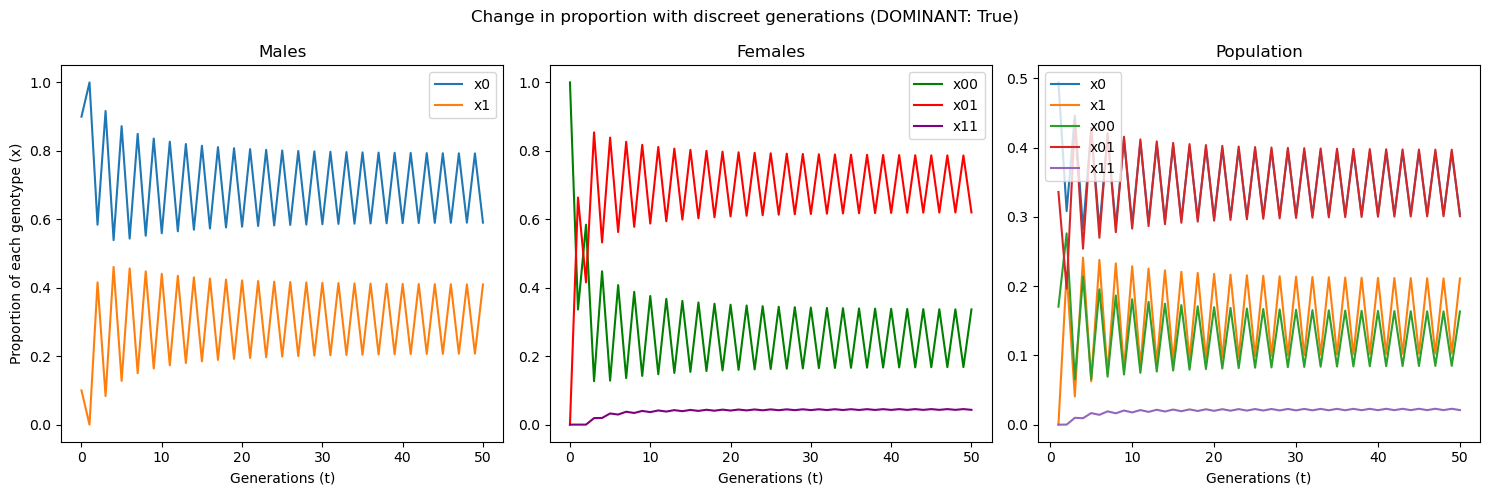

In [19]:
#Simulating proportions of each individual over a generation time
DOMINANT = True
gentime = 50

param = P.copy()
param['pm'] = 0.1
param['pf'] = 0.0

param['c'] = 1
param['a'] = 3

param['u'] = 0.1
param['r'] = (2 - param['u']) / 4

orgs = []

ind_prop = {
    'x0':[(1 - param['pm'])],
    'x1':[param['pm']],
    'x00':[(1 - param['pf']) * (1 - param['pf'])],
    'x01':[2 * param['pf'] * (1 - param['pf'])],
    'x11':[param['pf'] * param['pf']],
}

tot_prop = {
    'x0':[],
    'x1':[],
    'x00':[],
    'x01':[],
    'x11':[],
}

for t in tqdm(range(gentime)):
    prop_ls, org_ls = nexgen(param, orgs)

    ind_prop['x0'].append(org_ls[0] / (sum(org_ls[:2])))
    ind_prop['x1'].append(org_ls[1] / (sum(org_ls[:2])))
    ind_prop['x00'].append(org_ls[2] / (sum(org_ls[2:])))
    ind_prop['x01'].append(org_ls[3] / (sum(org_ls[2:])))
    ind_prop['x11'].append(org_ls[4] / (sum(org_ls[2:])))

    tot_prop['x0'].append(org_ls[0] / (sum(org_ls)))
    tot_prop['x1'].append(org_ls[1] / (sum(org_ls)))
    tot_prop['x00'].append(org_ls[2] / (sum(org_ls)))
    tot_prop['x01'].append(org_ls[3] / (sum(org_ls)))
    tot_prop['x11'].append(org_ls[4] / (sum(org_ls)))

    orgs = org_ls.copy()

    orgs[:2] = orgs[:2] / (sum(orgs[:2]))
    orgs[2:] = orgs[2:] / (sum(orgs[2:]))


fig, (ax0, ax1, ax2) = plt.subplots(ncols = 3, sharey = False, layout = 'tight', figsize = (15, 5))

ax0.plot(np.arange(0, gentime + 1, 1), ind_prop['x0'], label = 'x0')
ax0.plot(np.arange(0, gentime + 1, 1), ind_prop['x1'], label = 'x1')
ax0.legend()

ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['x00'], label = 'x00', c = 'g')
ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['x01'], label = 'x01', c = 'r')
ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['x11'], label = 'x11', c = 'purple')
ax1.legend()

ax2.plot(np.arange(1, gentime + 1, 1), tot_prop['x0'], label = 'x0')
ax2.plot(np.arange(1, gentime + 1, 1), tot_prop['x1'], label = 'x1')
ax2.plot(np.arange(1, gentime + 1, 1), tot_prop['x00'], label = 'x00')
ax2.plot(np.arange(1, gentime + 1, 1), tot_prop['x01'], label = 'x01')
ax2.plot(np.arange(1, gentime + 1, 1), tot_prop['x11'], label = 'x11')
ax2.legend()

ax0.set_title('Males')
ax1.set_title('Females')
ax2.set_title('Population')

ax0.set_xlabel('Generations (t)')
ax1.set_xlabel('Generations (t)')
ax2.set_xlabel('Generations (t)')

ax0.set_ylabel('Proportion of each genotype (x)')

fig.suptitle('Change in proportion with discreet generations (DOMINANT: ' + str(DOMINANT) + ')')

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Change in proportion with discreet generations (DOMINANT: False)')

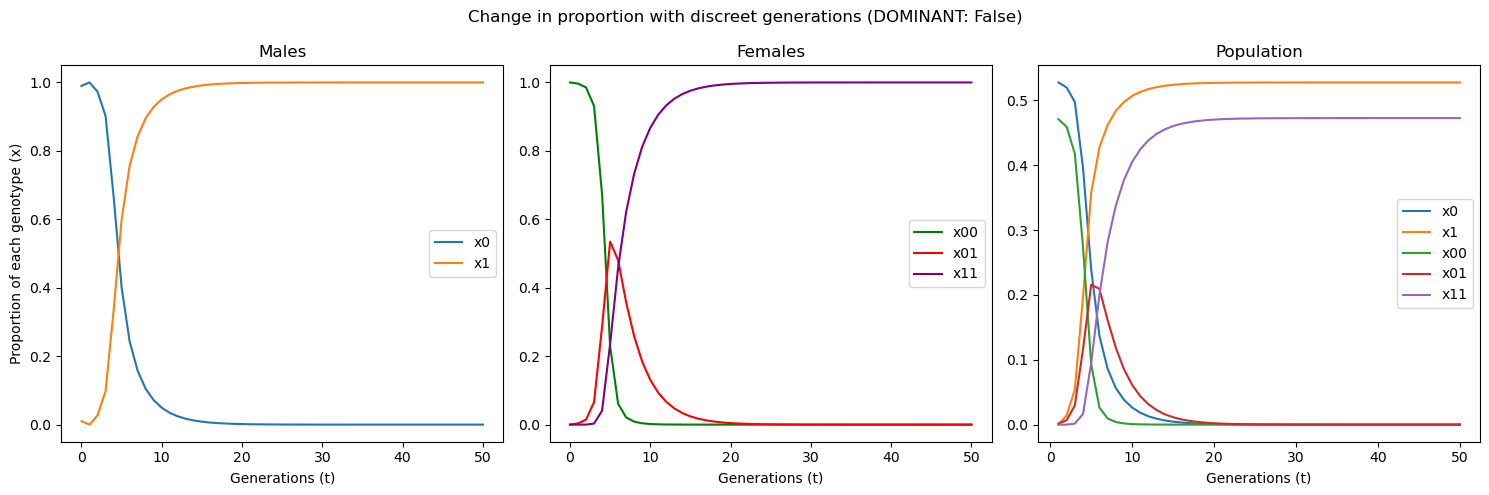

In [115]:
DOMINANT = False
#Simulating proportions of each individual over a generation time
gentime = 50

param = P.copy()
param['pm'] = 0.01
param['pf'] = 0.0

param['c'] = 20
param['a'] = 2.89

param['u'] = 0.1
param['r'] = (2 - param['u']) / 4

orgs = []

ind_prop = {
    'x0':[(1 - param['pm'])],
    'x1':[param['pm']],
    'x00':[(1 - param['pf']) * (1 - param['pf'])],
    'x01':[2 * param['pf'] * (1 - param['pf'])],
    'x11':[param['pf'] * param['pf']],
}

tot_prop = {
    'x0':[],
    'x1':[],
    'x00':[],
    'x01':[],
    'x11':[],
}

for t in tqdm(range(gentime)):
    prop_ls, org_ls = nexgen(param, orgs)

    ind_prop['x0'].append(org_ls[0] / (sum(org_ls[:2])))
    ind_prop['x1'].append(org_ls[1] / (sum(org_ls[:2])))
    ind_prop['x00'].append(org_ls[2] / (sum(org_ls[2:])))
    ind_prop['x01'].append(org_ls[3] / (sum(org_ls[2:])))
    ind_prop['x11'].append(org_ls[4] / (sum(org_ls[2:])))

    tot_prop['x0'].append(org_ls[0] / (sum(org_ls)))
    tot_prop['x1'].append(org_ls[1] / (sum(org_ls)))
    tot_prop['x00'].append(org_ls[2] / (sum(org_ls)))
    tot_prop['x01'].append(org_ls[3] / (sum(org_ls)))
    tot_prop['x11'].append(org_ls[4] / (sum(org_ls)))

    orgs = org_ls.copy()

    orgs[:2] = orgs[:2] / (sum(orgs[:2]))
    orgs[2:] = orgs[2:] / (sum(orgs[2:]))


fig, (ax0, ax1, ax2) = plt.subplots(ncols = 3, sharey = False, layout = 'tight', figsize = (15, 5))

ax0.plot(np.arange(0, gentime + 1, 1), ind_prop['x0'], label = 'x0')
ax0.plot(np.arange(0, gentime + 1, 1), ind_prop['x1'], label = 'x1')
ax0.legend()

ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['x00'], label = 'x00', c = 'g')
ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['x01'], label = 'x01', c = 'r')
ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['x11'], label = 'x11', c = 'purple')
ax1.legend()

ax2.plot(np.arange(1, gentime + 1, 1), tot_prop['x0'], label = 'x0')
ax2.plot(np.arange(1, gentime + 1, 1), tot_prop['x1'], label = 'x1')
ax2.plot(np.arange(1, gentime + 1, 1), tot_prop['x00'], label = 'x00')
ax2.plot(np.arange(1, gentime + 1, 1), tot_prop['x01'], label = 'x01')
ax2.plot(np.arange(1, gentime + 1, 1), tot_prop['x11'], label = 'x11')
ax2.legend()

ax0.set_title('Males')
ax1.set_title('Females')
ax2.set_title('Population')

ax0.set_xlabel('Generations (t)')
ax1.set_xlabel('Generations (t)')
ax2.set_xlabel('Generations (t)')

ax0.set_ylabel('Proportion of each genotype (x)')

fig.suptitle('Change in proportion with discreet generations (DOMINANT: ' + str(DOMINANT) + ')')

# Heatmaps of defender proportions in recessive and dominant cases

In [103]:
DOMINANT = True

range_c = np.linspace(1, 20, 20, dtype = 'int')
range_a = np.round(np.linspace(1, 3, 20), 2)

param = P.copy()
param['pm'] = 0.1
param['pf'] = 0.1

param['u'] = 0.0
param['r'] = (2 - param['u']) / 4

gentime = 50

data_dom = []

for i in tqdm(range_a):
    data_a = []
    param['a'] = i
    for j in range_c:
        param['c'] = j

        orgs = []
        for t in range(gentime):
            prop_ls, org_ls = nexgen(param, orgs)

            orgs = org_ls.copy()

            orgs[:2] = orgs[:2] / (sum(orgs[:2]))
            orgs[2:] = orgs[2:] / (sum(orgs[2:]))
            
                
        if DOMINANT:
            total_def = (org_ls[1] + org_ls[3] + org_ls[4]) / sum(org_ls)
            male_def = org_ls[1] / (org_ls[1] + org_ls[3] + org_ls[4])
            female_def = 1 - male_def
        else:
            total_def = (org_ls[1] + org_ls[4]) / sum(org_ls)
            male_def = org_ls[1] / (org_ls[1] + org_ls[4])
            female_def = 1 - male_def

        data_c = [total_def, male_def, female_def]
        data_a.append(data_c)
    data_dom.append(data_a)

size_data_dom = np.array([[data_dom[i][j][0] for j in range(len(data_dom[i]))] for i in range(len(data_dom))])
prop_data_dom = np.array([[data_dom[i][j][2] - data_dom[i][j][1] for j in range(len(data_dom[i]))] for i in range(len(data_dom))])

plot_hm_dom = pd.DataFrame(data = prop_data_dom, columns = range_c, index = range_a)
plot_anno_dom = pd.DataFrame(data = size_data_dom, columns = range_c, index = range_a)

  0%|          | 0/20 [00:00<?, ?it/s]

In [104]:
DOMINANT = False

range_c = np.linspace(1, 20, 20, dtype = 'int')
range_a = np.round(np.linspace(1, 3, 20), 2)

param = P.copy()
param['pm'] = 0.1
param['pf'] = 0.1

param['u'] = 0.0
param['r'] = (2 - param['u']) / 4

gentime = 50

data_rec = []

for i in tqdm(range_a):
    data_a = []
    param['a'] = i
    for j in range_c:
        param['c'] = j

        orgs = []
        for t in range(gentime):
            prop_ls, org_ls = nexgen(param, orgs)

            orgs = org_ls.copy()

            orgs[:2] = orgs[:2] / (sum(orgs[:2]))
            orgs[2:] = orgs[2:] / (sum(orgs[2:]))
        
        if DOMINANT:
            total_def = (org_ls[1] + org_ls[3] + org_ls[4]) / sum(org_ls)
            male_def = org_ls[1] / (org_ls[1] + org_ls[3] + org_ls[4])
            female_def = 1 - male_def
        else:
            total_def = (org_ls[1] + org_ls[4]) / sum(org_ls)
            male_def = org_ls[1] / (org_ls[1] + org_ls[4])
            female_def = 1 - male_def

        data_c = [total_def, male_def, female_def]
        data_a.append(data_c)
    data_rec.append(data_a)

size_data_rec = np.array([[data_rec[i][j][0] for j in range(len(data_rec[i]))] for i in range(len(data_rec))])
prop_data_rec = np.array([[data_rec[i][j][2] - data_rec[i][j][1] for j in range(len(data_rec[i]))] for i in range(len(data_rec))])

plot_hm_rec = pd.DataFrame(data = prop_data_rec, columns = range_c, index = range_a)
plot_anno_rec = pd.DataFrame(data = size_data_rec, columns = range_c, index = range_a)


  0%|          | 0/20 [00:00<?, ?it/s]

### With u = 0.0

Text(0.5, 0.98, 'Proportion of Male and Female defenders in the population')

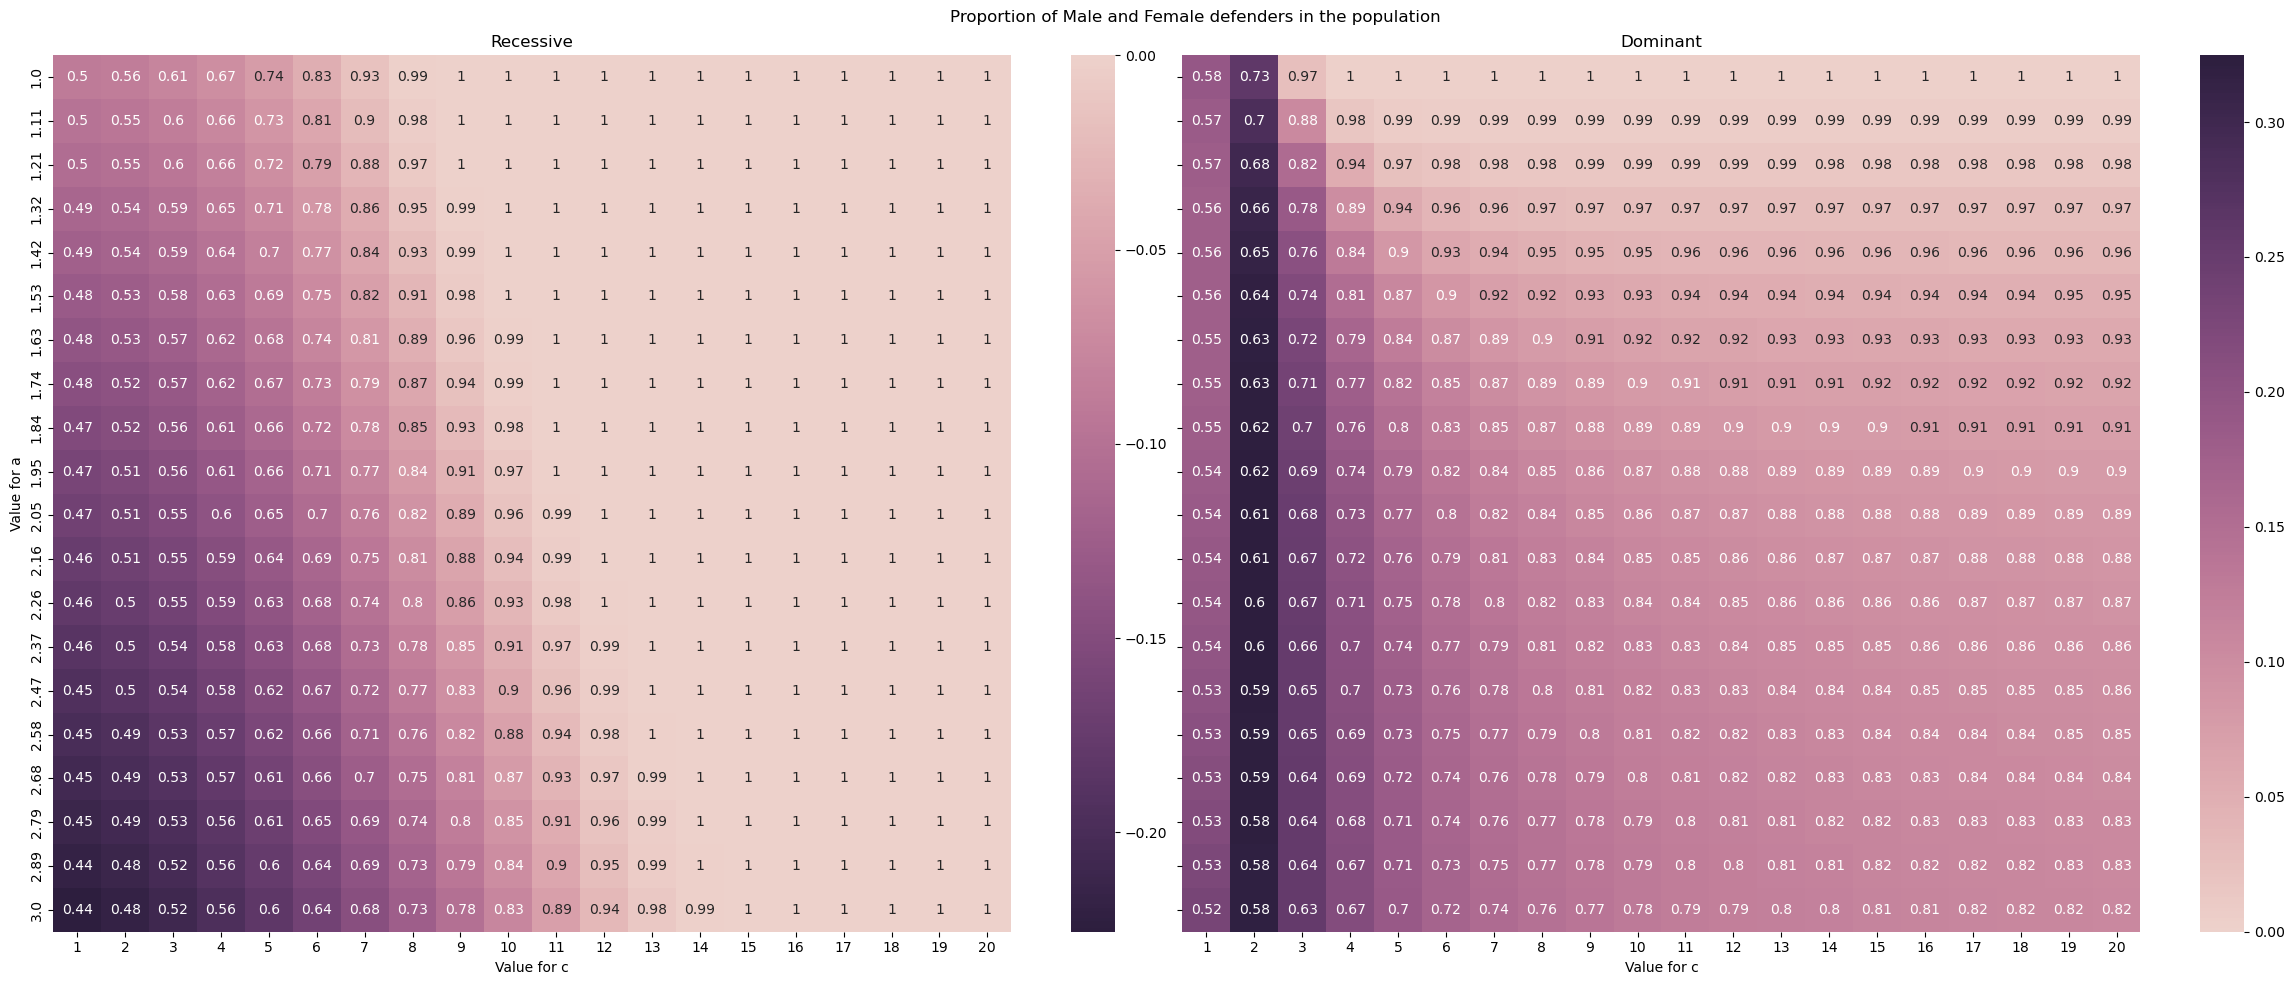

In [105]:
#Recessive
fig, (ax_rec, ax_dom) = plt.subplots(nrows = 1, ncols = 2, figsize = (24,10), sharey = True, layout = 'tight')
sns.heatmap(plot_hm_rec, annot=plot_anno_rec, cmap = sns.cubehelix_palette(reverse = True, as_cmap=True), vmax = 0, ax = ax_rec)
sns.heatmap(plot_hm_dom, annot=plot_anno_dom, cmap = sns.cubehelix_palette(as_cmap=True), vmin = 0, ax = ax_dom)

ax_rec.set_title('Recessive')
ax_dom.set_title('Dominant')

ax_rec.set_xlabel('Value for c')
ax_dom.set_xlabel('Value for c')

ax_rec.set_ylabel('Value for a')

fig.suptitle('Proportion of Male and Female defenders in the population')

### With u = 0.1

Text(0.5, 0.98, 'Proportion of Male and Female defenders in the population')

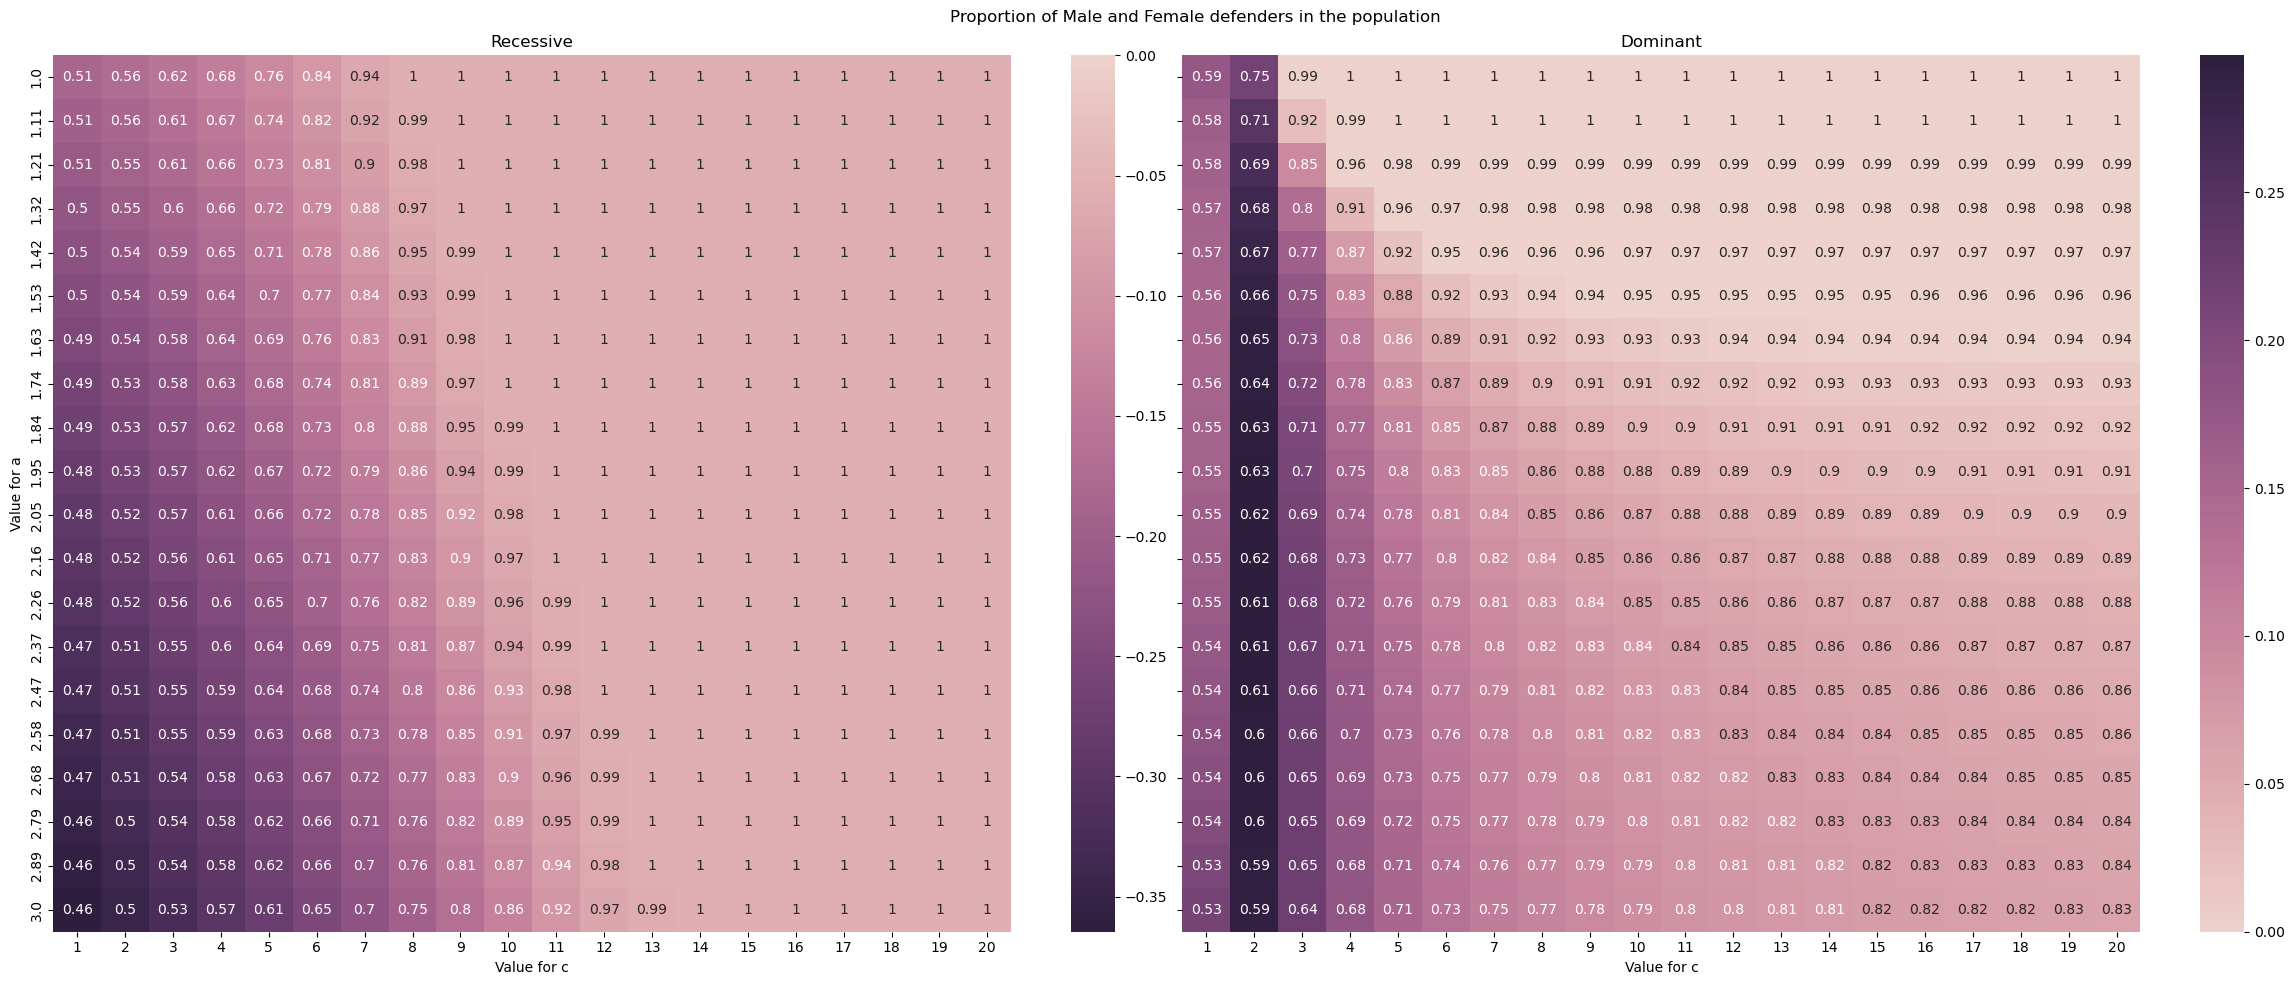

In [59]:
#Recessive
fig, (ax_rec, ax_dom) = plt.subplots(nrows = 1, ncols = 2, figsize = (24,10), sharey = True, layout = 'tight')
sns.heatmap(plot_hm_rec, annot=plot_anno_rec, cmap = sns.cubehelix_palette(reverse = True, as_cmap=True), vmax = 0, ax = ax_rec)
sns.heatmap(plot_hm_dom, annot=plot_anno_dom, cmap = sns.cubehelix_palette(as_cmap=True), vmin = 0, ax = ax_dom)

ax_rec.set_title('Recessive')
ax_dom.set_title('Dominant')

ax_rec.set_xlabel('Value for c')
ax_dom.set_xlabel('Value for c')

ax_rec.set_ylabel('Value for a')

fig.suptitle('Proportion of Male and Female defenders in the population')

# Using difference in proportion of defender in respective sexes

In [118]:
DOMINANT = True

range_c = np.linspace(1, 20, 20, dtype = 'int')
range_a = np.round(np.linspace(1, 3, 20), 2)

param = P.copy()
param['pm'] = 0.1
param['pf'] = 0.1

param['u'] = 0.1
param['r'] = (2 - param['u']) / 4

gentime = 50

data_dom = []

for i in tqdm(range_a):
    data_a = []
    param['a'] = i
    for j in range_c:
        param['c'] = j

        orgs = []
        for t in range(gentime):
            prop_ls, org_ls = nexgen(param, orgs)

            orgs = org_ls.copy()

            orgs[:2] = orgs[:2] / (sum(orgs[:2]))
            orgs[2:] = orgs[2:] / (sum(orgs[2:]))
            
                
        if DOMINANT:
            total_def = (org_ls[1] + org_ls[3] + org_ls[4]) / sum(org_ls)
            male_def = org_ls[1] / (org_ls[1] + org_ls[0])
            female_def = (org_ls[3] + org_ls[4]) / (org_ls[2] + org_ls[3] + org_ls[4])
        else:
            total_def = (org_ls[1] + org_ls[4]) / sum(org_ls)
            male_def = org_ls[1] / (org_ls[1] + org_ls[0])
            female_def = (org_ls[4]) / (org_ls[2] + org_ls[3] + org_ls[4])

        data_c = [total_def, male_def, female_def]
        data_a.append(data_c)
    data_dom.append(data_a)

size_data_dom = np.array([[data_dom[i][j][0] for j in range(len(data_dom[i]))] for i in range(len(data_dom))])
prop_data_dom = np.array([[data_dom[i][j][2] - data_dom[i][j][1] for j in range(len(data_dom[i]))] for i in range(len(data_dom))])

plot_hm_dom = pd.DataFrame(data = prop_data_dom, columns = range_c, index = range_a)
plot_anno_dom = pd.DataFrame(data = size_data_dom, columns = range_c, index = range_a)

  0%|          | 0/20 [00:00<?, ?it/s]

In [107]:
DOMINANT = False

range_c = np.linspace(1, 20, 20, dtype = 'int')
range_a = np.round(np.linspace(1, 3, 20), 2)

param = P.copy()
param['pm'] = 0.1
param['pf'] = 0.1

param['u'] = 0.1
param['r'] = (2 - param['u']) / 4

gentime = 50

data_rec = []

for i in tqdm(range_a):
    data_a = []
    param['a'] = i
    for j in range_c:
        param['c'] = j

        orgs = []
        for t in range(gentime):
            prop_ls, org_ls = nexgen(param, orgs)

            orgs = org_ls.copy()

            orgs[:2] = orgs[:2] / (sum(orgs[:2]))
            orgs[2:] = orgs[2:] / (sum(orgs[2:]))
            
                
        if DOMINANT:
            total_def = (org_ls[1] + org_ls[3] + org_ls[4]) / sum(org_ls)
            male_def = org_ls[1] / (org_ls[1] + org_ls[0])
            female_def = (org_ls[3] + org_ls[4]) / (org_ls[2] + org_ls[3] + org_ls[4])
        else:
            total_def = (org_ls[1] + org_ls[4]) / sum(org_ls)
            male_def = org_ls[1] / (org_ls[1] + org_ls[0])
            female_def = (org_ls[4]) / (org_ls[2] + org_ls[3] + org_ls[4])

        data_c = [total_def, male_def, female_def]
        data_a.append(data_c)
    data_rec.append(data_a)

size_data_rec = np.array([[data_rec[i][j][0] for j in range(len(data_rec[i]))] for i in range(len(data_rec))])
prop_data_rec = np.array([[data_rec[i][j][2] - data_rec[i][j][1] for j in range(len(data_rec[i]))] for i in range(len(data_rec))])

plot_hm_rec = pd.DataFrame(data = prop_data_rec, columns = range_c, index = range_a)
plot_anno_rec = pd.DataFrame(data = size_data_rec, columns = range_c, index = range_a)

  0%|          | 0/20 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Difference in proportion of Male and Female defenders')

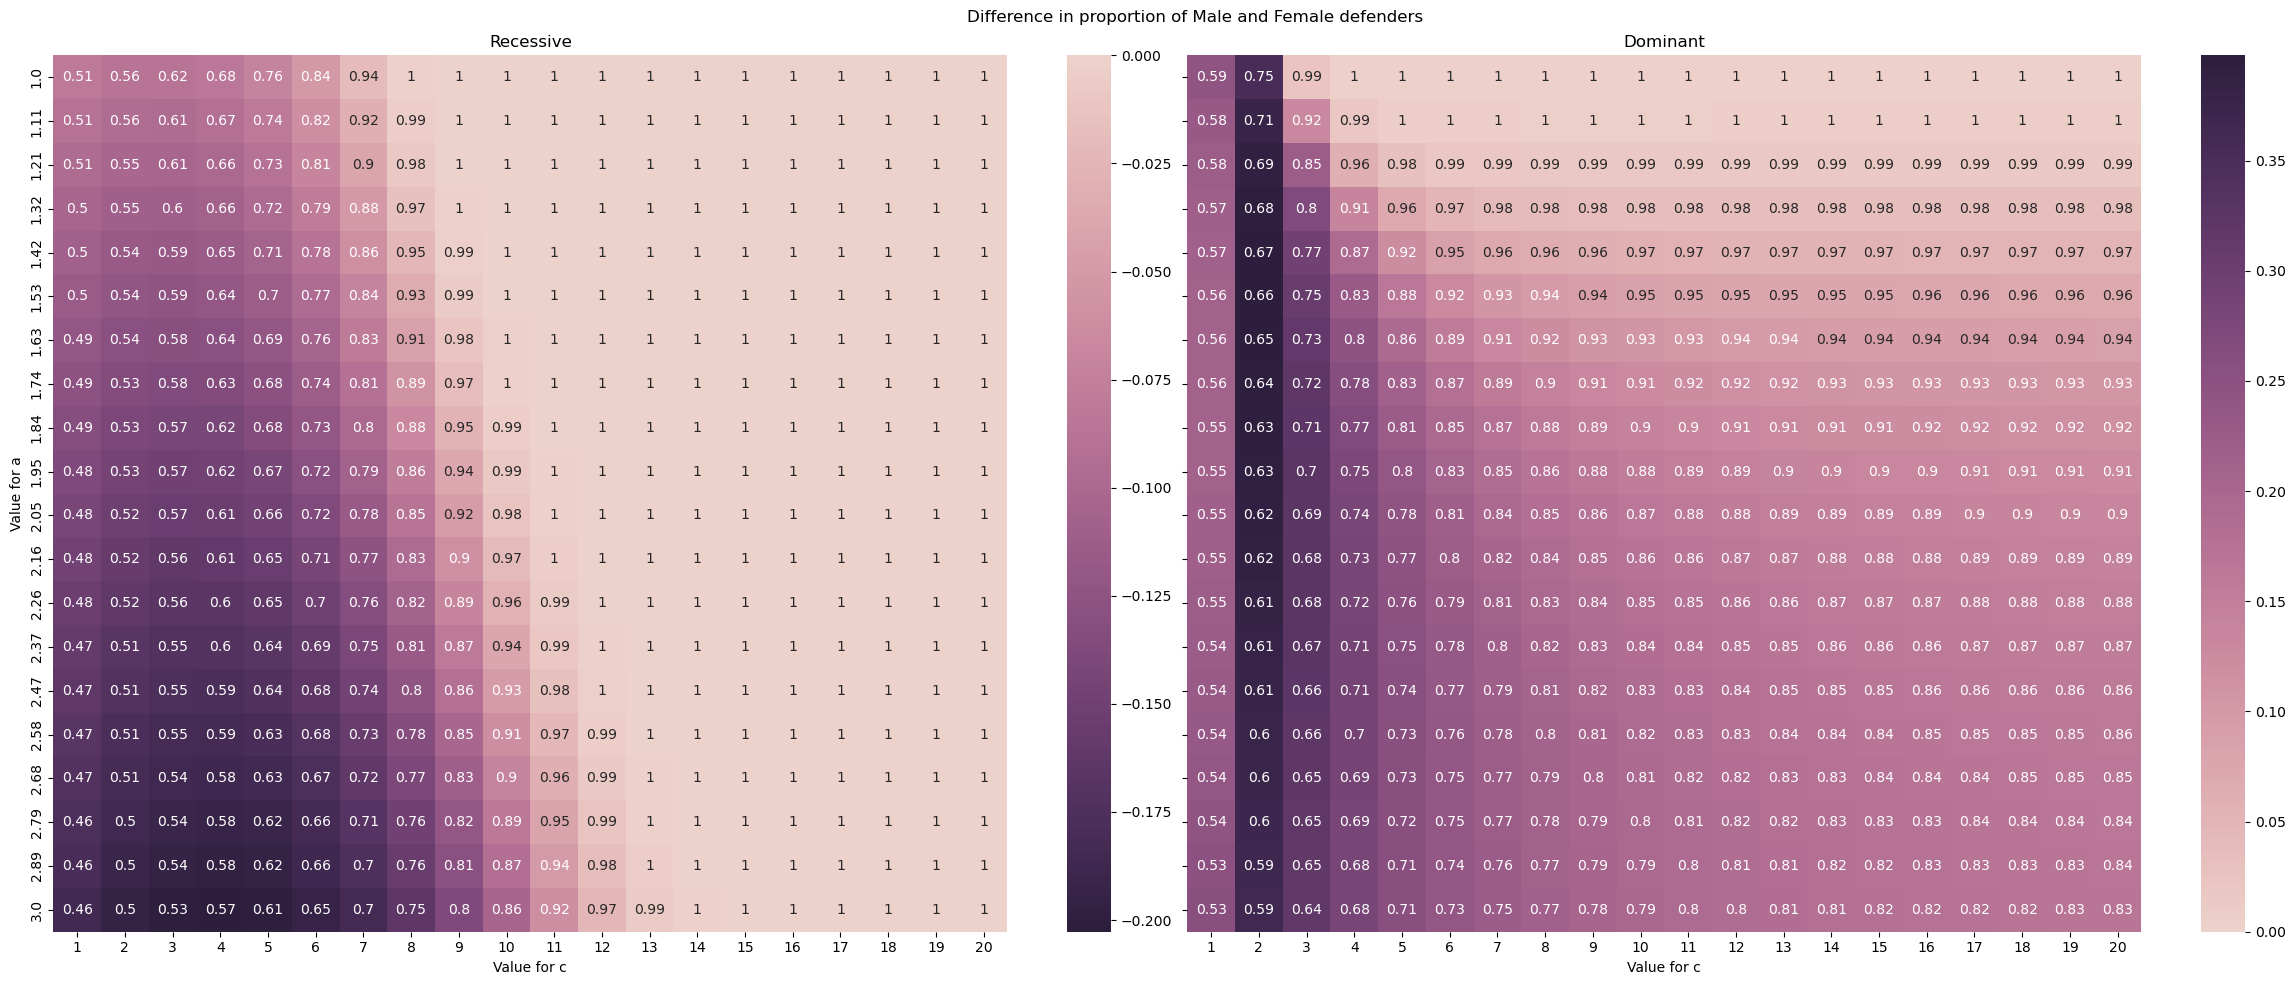

In [119]:
fig, (ax_rec, ax_dom) = plt.subplots(nrows = 1, ncols = 2, figsize = (24,10), sharey = True, layout = 'tight')
sns.heatmap(plot_hm_rec, annot=plot_anno_rec, cmap = sns.cubehelix_palette(reverse = True, as_cmap=True), vmax = 0, ax = ax_rec)
sns.heatmap(plot_hm_dom, annot=plot_anno_dom, cmap = sns.cubehelix_palette(as_cmap=True), vmin = 0, ax = ax_dom)

ax_rec.set_title('Recessive')
ax_dom.set_title('Dominant')

ax_rec.set_xlabel('Value for c')
ax_dom.set_xlabel('Value for c')

ax_rec.set_ylabel('Value for a')

fig.suptitle('Difference in proportion of Male and Female defenders')